# Intro

Partial differential equations (PDEs) are multivariate differential equations where
derivatives of more than one dependent variable occur. That is, the derivatives in the
equation are partial derivatives. As such they are generalizations of ordinary differential
equations, which were covered in Chapter 9. Conceptually, the difference between
ordinary and partial differential equations is not that big, but the computational
techniques required to deal with ODEs and PDEs are very different, and solving PDEs
is typically much more computationally demanding. Most techniques for solving PDEs
numerically are based on the idea of discretizing the problem in each independent
variable that occurs in the PDE, thereby recasting the problem into an algebraic form.
This usually results in very large-scale linear algebra problems. Two common techniques
for recasting PDEs into algebraic form are the finite-difference methods (FDMs), where
the derivatives in the problem are approximated with their finite-difference formula,
and the finite-element methods (FEMs), where the unknown function is written as
linear combination of simple basis functions that can be differentiated and integrated
easily. The unknown function is described by a set of coefficients for the basis functions
in this representation, and by a suitable rewriting of the PDEs, we can obtain algebraic
equations for these coefficients.

With both FDMs and FEMs, the resulting algebraic equation system is usually very
large, and in the matrix form, such equation systems are usually very sparse. Both FDM
and FEM therefore heavily rely on sparse matrix representation for the algebraic linear
equations, as discussed in Chapter 10. Most general-purpose frameworks for PDEs are
based on FEM, or some variant thereof, as this method allows for solving very general
problems on complicated problem domains

### Importing Modules

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d
import numpy as np

We also use the `linalg` and the `sparse` modules from SciPy, and to use the `linalg`
submodule of the sparse module, we also need to import it explicitly

In [2]:
import scipy.linalg as la
import scipy.sparse as sp
import scipy.sparse.linalg

With these imports, we can access the dense linear algebra module as `la`, while
the sparse linear algebra module is accessed as `sp.linalg`. Furthermore, later in this
chapter, we will also use the FEniCS FEM framework, and we require that its `dolfin` and
`mshr` libraries be imported in the following manner

In [3]:
import dolfin
import mshr

# Partial Differential Equations and Finite Difference Method

In Python code, we can set up and solve this problem in the following way: First,
we define variables for the number of interior points `N`, the values of the function at the
boundaries `u0` and `u1`, as well as the spacing between neighboring points `dx`.

In [12]:
N = 5
u0, u1 = 1, 2
dx = 1.0 / (N + 1)

Next we construct the matrix `A` as described in the preceding section. For this we can
use the `eye` function from NumPy, which creates a two-dimensional array with ones on
the diagonal or on the upper or lower diagonal that is shifted from the main diagonal by
the number given by the argument `k`

In [14]:
# Matrix K
K = np.eye(N, k=-1) - 2 * np.eye(N) + np.eye(N, k=1)
K

array([[-2.,  1.,  0.,  0.,  0.],
       [ 1., -2.,  1.,  0.,  0.],
       [ 0.,  1., -2.,  1.,  0.],
       [ 0.,  0.,  1., -2.,  1.],
       [ 0.,  0.,  0.,  1., -2.]])

In [16]:
# Matrix A
A = (1 / dx ** 2) * K
A

array([[-72.,  36.,   0.,   0.,   0.],
       [ 36., -72.,  36.,   0.,   0.],
       [  0.,  36., -72.,  36.,   0.],
       [  0.,   0.,  36., -72.,  36.],
       [  0.,   0.,   0.,  36., -72.]])

Next we need to define an array for the vector `b`, which corresponds to the source
term `–5` in the differential equation, as well as the boundary condition. The boundary
conditions enter into the equations via the finite-difference expressions for the
derivatives of the first and the last equation (for `u1` and `uN`), but these terms are missing
from the expression represented by the matrix `A` and must therefore be added to the
vector `b`

In [17]:
# Add boundaries to vector
b = -5 * np.ones(N)
b[0] -= u0 / dx ** 2
b[N - 1] -= u1 / dx ** 2

b

array([-41.,  -5.,  -5.,  -5., -77.])

Once the matrix `A` and the vector `b` are defined, we can proceed to solve the equation
system using the linear equation solver from SciPy (we could also use the one provided
by NumPy, `np.linalg.solve`).

In [28]:
# Solution
u = la.solve(A, b)

u

array([1.51388889, 1.88888889, 2.125     , 2.22222222, 2.18055556])

This completes the solution of this ODE problem. To visualize the solution, here
we first create an array `x` that contains the discrete coordinate points for which we have
solved the problem, including the boundary points, and we also create an array `U` that
combines the boundary values and the interior points in one array. The result is then
plotted and shown in Figure

In [27]:
x = np.linspace(0, 1, N + 2)

# Just merge the arrays
U = np.hstack([[u0], u, [u1]])

x, U

(array([0.        , 0.16666667, 0.33333333, 0.5       , 0.66666667,
        0.83333333, 1.        ]),
 array([1.        , 1.51388889, 1.88888889, 2.125     , 2.22222222,
        2.18055556, 2.        ]))

Text(0, 0.5, '$u(x)$')

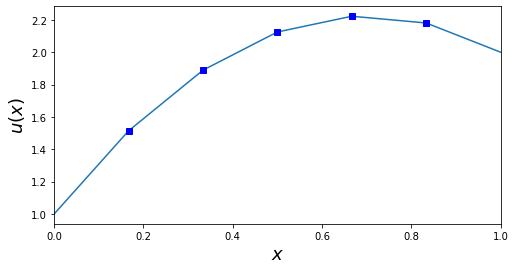

In [26]:
fig, ax = plt.subplots(figsize=(8, 4))

ax.plot(x, U)

# The exact solution points
ax.plot(x[1:-1], u, "bs")

ax.set_xlim(0, 1)
ax.set_xlabel(r"$x$", fontsize=18)
ax.set_ylabel(r"$u(x)$", fontsize=18)

> Solution to the second-order ODE boundary value problem
introduced in the text

The finite-difference method can easily be extended to higher dimensions by using
the finite-difference formula along each discretized coordinate. For a two-dimensional
problem, we have a two-dimensional array `u` for the unknown interior function values,
and when using the finite differential formula, we obtain a system of coupled equations
for the elements in `u`. To write these equations on the standard matrix-vector form, we
can rearrange the `u` array into a vector and assemble the corresponding matrix `A` from
the finite-difference equations

As an example, consider the following two-dimensional generalization of the
previous problem: $u_{xx}+u_{yy} = 0$, with the boundary conditions $u(x = 0) = 3$, $u(x = 1) = −1$,
$u(y = 0) = −5$, and $u(y = 1) = 5$

Here there is no source term, but the boundary
conditions in a two-dimensional problem are more complicated than in the one-dimensional problem we solved earlier. In finite-difference form, we can write the PDE as

$$
\frac{(u_{m − 1},n − 2u_{m,n} + u_{m+1,n})}{\nabla x^2} + \frac{(u_{m,n − 1} − 2 u_{m,n}+u_{m,n+1})}{\nabla y^2} = 0
$$

If we divide the $x$ and $y$ intervals into $N$ interior points ($N+2$ points including the boundary points), then

$\nabla x \nabla y = \frac{1}{N+1}$, and `u` is an `NxN` matrix.

To write the equation on the standard form Av = b, we can rearrange the matrix `u` by stacking its rows or columns into a vector of
size $N^2 × 1$. The matrix $A$ is then of size $N^2 × N^2$, which can be very big if we need to use
a fine discretization of the `x` and `y` coordinates. For example, using 100 points along
both `x` and `y` gives an equation system that has 104 unknown values $u_{mn}$, and the matrix
`A` has 1004 = 108 elements. Fortunately, since the finite-difference formula only couples
neighboring points, the matrix `A` turns out to be very sparse, and here we can benefit
greatly from working with sparse matrices, as we will see in the following.

To solve this PDE problem with Python and the finite-element method, we start
by defining variables for the number of interior points and the values along the four
boundaries of the unit square:

In [103]:
# Example with small N
N = 3
dx = 1.0 / (N + 1)

# Small K
K = (sp.eye(N, k=-1) + sp.eye(N, k=1) - 4 * sp.eye(N)) / dx ** 2
K.toarray()

array([[-64.,  16.,   0.],
       [ 16., -64.,  16.],
       [  0.,  16., -64.]])

#### Kron with I matrix it's the easiest way to grow for this matrix

In [104]:
# Real K
K_NN = sp.kron(sp.eye(N), K)

K_NN.toarray()

array([[-64.,  16.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [ 16., -64.,  16.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,  16., -64.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0., -64.,  16.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,  16., -64.,  16.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,  16., -64.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0., -64.,  16.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,  16., -64.,  16.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,  16., -64.]])

### K off-diagonals values

In [105]:
K_od = (sp.eye(N ** 2, k=-N) + sp.eye(N ** 2, k=N)) / dx ** 2

K_od.toarray()

array([[ 0.,  0.,  0., 16.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0., 16.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0., 16.,  0.,  0.,  0.],
       [16.,  0.,  0.,  0.,  0.,  0., 16.,  0.,  0.],
       [ 0., 16.,  0.,  0.,  0.,  0.,  0., 16.,  0.],
       [ 0.,  0., 16.,  0.,  0.,  0.,  0.,  0., 16.],
       [ 0.,  0.,  0., 16.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0., 16.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0., 16.,  0.,  0.,  0.]])

In [106]:
A = K_NN + K_od
A.toarray()

array([[-64.,  16.,   0.,  16.,   0.,   0.,   0.,   0.,   0.],
       [ 16., -64.,  16.,   0.,  16.,   0.,   0.,   0.,   0.],
       [  0.,  16., -64.,   0.,   0.,  16.,   0.,   0.,   0.],
       [ 16.,   0.,   0., -64.,  16.,   0.,  16.,   0.,   0.],
       [  0.,  16.,   0.,  16., -64.,  16.,   0.,  16.,   0.],
       [  0.,   0.,  16.,   0.,  16., -64.,   0.,   0.,  16.],
       [  0.,   0.,   0.,  16.,   0.,   0., -64.,  16.,   0.],
       [  0.,   0.,   0.,   0.,  16.,   0.,  16., -64.,  16.],
       [  0.,   0.,   0.,   0.,   0.,  16.,   0.,  16., -64.]])

### Boundaries example with small N

In [113]:
u0_t, u0_b = 5, -5
u0_l, u0_r = 3, -1

b = np.zeros((N, N))

# top
b[-1, :] += u0_t

# bottom
b[0, :] += u0_b

# left
b[:, 0] += u0_l

# right
b[:, -1] += u0_r

b

array([[-2., -5., -6.],
       [ 3.,  0., -1.],
       [ 8.,  5.,  4.]])

In [109]:
b = -b.reshape(N ** 2) / dx ** 2

b

array([  32.,   80.,   96.,  -48.,   -0.,   16., -128.,  -80.,  -64.])

In [114]:
N = 100
dx = 1.0 / (N + 1)

u0_t, u0_b = 5, -5
u0_l, u0_r = 3, -1

We also computed the separation `dx` between the uniformly spaced coordinate
points in the discretization of `x` and `y` (assumed equal). Because the finite-difference
formula couples both neighboring rows and columns, it is slightly more involved to
construct the matrix `A` for this example. However, a relatively direct approach is to first
define the matrix `A_1d` that corresponds to the one-dimensional formula along one of the
coordinates (say x or the index m in um,n). To distribute this formula along each row, we
can take the tensor product of the identity matrix of size `N × N` with the `A_1d` matrix. The
result describes all derivatives along the m-index for all indices `n`. To cover the terms that
couple the equation for $u_{m,n}$ to $u_{m,n+1}$ and $u_{m,n − 1}$, that is, the derivatives along the index
`n`, we need to add diagonals that are separated from the main diagonal by `N` positions.
In the following we perform these steps to construct `A` using the `eye` and `kron` functions
from the `scipy.sparse` module. The result is a sparse matrix `A` that describes the finite-
difference equation system for the two-dimensional PDE we are considering here

In [115]:
A_1d = (sp.eye(N, k=-1) + sp.eye(N, k=1) - 4 * sp.eye(N)) / dx ** 2

A = sp.kron(sp.eye(N), A_1d) + (sp.eye(N ** 2, k=-N) + sp.eye(N ** 2, k=N)) / dx ** 2

A

<10000x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 49600 stored elements in Compressed Sparse Row format>

In [116]:
b = np.zeros((N, N))

# top
b[-1, :] += u0_t
# bottom
b[0, :] += u0_b
# left
b[:, 0] += u0_l
# right
b[:, -1] += u0_r

b = -b.reshape(N ** 2) / dx ** 2

When the `A` and `b` arrays are created, we can proceed to solve the equation system for
the vector `v` and use the reshape method to arrange it back into the `N × N` matrix `u`:

In [119]:
v = sp.linalg.spsolve(A, b)
u = v.reshape(N, N)

For plotting purposes, we also create a matrix `U` that combines the `u` matrix with the
boundary conditions. Together with the coordinate matrices `X` and `Y`, we then plot a
colormap graph and a 3D surface view of the solution. The result is shown in Figure

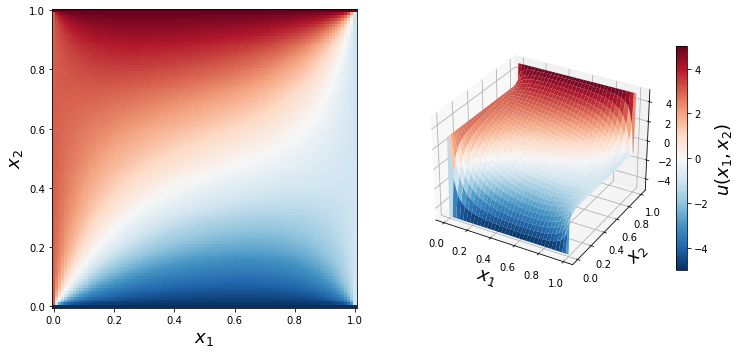

In [122]:
U = np.vstack(
    [
        np.ones((1, N + 2)) * u0_b,
        np.hstack([np.ones((N, 1)) * u0_l, u, np.ones((N, 1)) * u0_r]),
        np.ones((1, N + 2)) * u0_t,
    ]
)

x = np.linspace(0, 1, N + 2)

X, Y = np.meshgrid(x, x)

fig = plt.figure(figsize=(12, 5.5))
cmap = mpl.cm.get_cmap("RdBu_r")

ax = fig.add_subplot(1, 2, 1)
c = ax.pcolor(X, Y, U, vmin=-5, vmax=5, cmap=cmap)

ax.set_xlabel(r"$x_1$", fontsize=18)
ax.set_ylabel(r"$x_2$", fontsize=18)

ax = fig.add_subplot(1, 2, 2, projection="3d")
p = ax.plot_surface(
    X, Y, U, vmin=-5, vmax=5, rstride=3, cstride=3, linewidth=0, cmap=cmap
)

ax.set_xlabel(r"$x_1$", fontsize=18)
ax.set_ylabel(r"$x_2$", fontsize=18)

cb = plt.colorbar(p, ax=ax, shrink=0.75)
cb.set_label(r"$u(x_1, x_2)$", fontsize=18)

> The solution to the two-dimensional heat equation with Dirichlet
boundary conditions defined in the text